In [77]:
import matplotlib.pyplot as plt
import numpy as np
import os, scipy
import pickle

if os.getcwd().split("/")[-1] == "examples":
    os.chdir('..')


from neurolib.models.wc import WCModel
from neurolib.optimal_control.oc_utils.plot_oc import get_prc, plot_prc
    
# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [78]:
wc = WCModel()
dur = 2000
wc.params['duration'] = dur

control0 = np.zeros(dur*10+1)
control0[:1000] = 5.
control0[10000:11000] = -5.

ones = np.ones(dur*10+1)

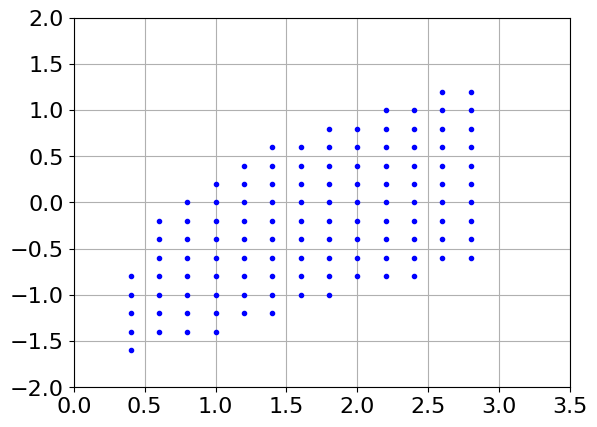

In [51]:
step = 0.2

exc_inputs = np.around(np.arange(0, 3., step), 3)
inh_inputs = np.around(np.arange(-2, 2., step), 3)

limit_std_osc = 1e-2
limit_mean_osc = 1e-1
limit_down = 0.15

osc = []

wc = WCModel()
wc.params['duration'] = dur

wc.params.c_inhexc = 16
wc.params.c_excinh = 10
wc.params.c_inhinh = 1

for i in inh_inputs:
    for e in exc_inputs:
    
        wc.params['exc_ext'] = e * ones + control0
        wc.params['inh_ext'] = i * ones
        wc.run()

        mean_std_0 = [np.mean(wc.exc[0,9000:9999]), np.std(wc.exc[0,9000:9999])]
        mean_std_1 = [np.mean(wc.exc[0,-1000:]), np.std(wc.exc[0,-1000:])]

        if mean_std_0[1] >= limit_std_osc:    # first state osc
            if np.abs(mean_std_0[0] - mean_std_1[0]) < limit_mean_osc:   # same oscillation
                #print("oscillatory state")
                osc.append([e,i])

            else:
                print("oscillation with different mean?", e,i)
                plt.plot(wc.t, wc.exc[0,:])
                plt.show()

plt_wc_statespace_osc(osc)



In [79]:
# check for every fourth point in oscillatory regime whether i response larger e response
indlist = np.linspace(0, len(osc)-1, 6)
for i in range(len(indlist)):
    indlist[i] = np.around(indlist[i]).astype(int)


prc_results = dict([
    #('point', [ osc[int(indlist[0])], osc[int(indlist[1])], osc[int(indlist[2])], osc[int(indlist[3])], osc[int(indlist[4])], osc[int(indlist[5])] ]),
    ('point', [ [1., 0.], [2.5, 0], [2.6, 1.2], [1.75, 0.], [2.8, 1.2] ]),
    ('ep', [None, None, None, None, None ]),
    ('em', [None, None, None, None, None ]),
    ('ip', [None, None, None, None, None ]),
    ('im', [None, None, None, None, None ]),
    ('period', [ np.zeros((len(dist_array))), np.zeros((len(dist_array))), np.zeros((len(dist_array))), np.zeros((len(dist_array))), np.zeros((len(dist_array))) ] ),
])

In [65]:
wc = WCModel()

dist_array = [1.]
width_array = [0.1]
dt_array = [0.01]

for ip in range(len(prc_results["point"])):
    p = prc_results["point"][ip]
    print(p)

    if ip in [2]:
        continue

    if ip == 4:
        wc.params.c_inhexc = 16
        wc.params.c_excinh = 10
        wc.params.c_inhinh = 1

    prc_results["ep"][ip], prc_results["em"][ip], prc_results["ip"][ip], prc_results["im"][ip], prc_results["period"][ip] = get_prc(wc, p, dist_array, width_array, dt_array, norm=False)


[1.0, 0.0]
0
[2.5, 0]
0
[2.6, 1.2]
[1.75, 0.0]
0
[2.8, 1.2]
0


0
1
2
3
4


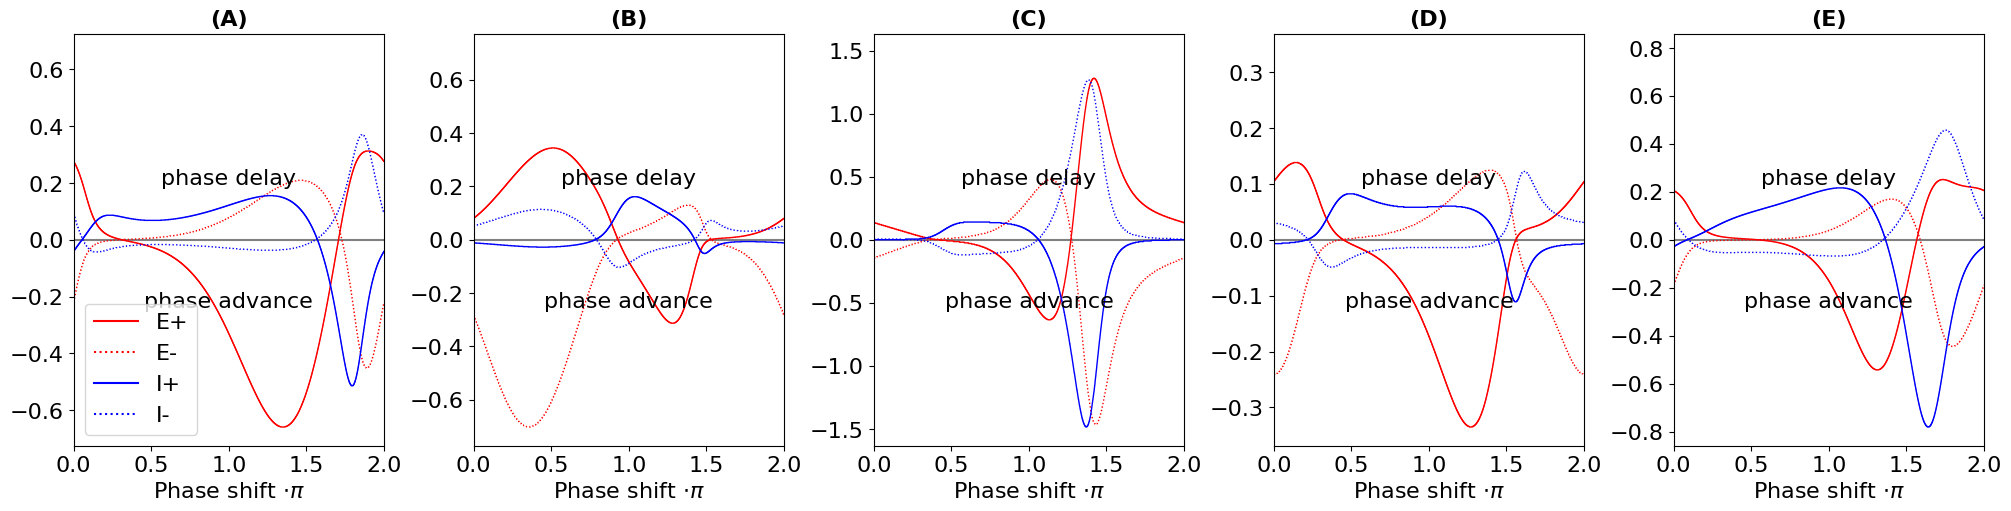

In [67]:
# parameter set 
#wc.params.c_inhexc = 16
# c_excinh = 10
#wc.params.c_inhinh = 1
savepath = ( '..' + os.sep + '..' + os.sep + '..' + os.sep + '..' + os.sep + 'writing' + os.sep +
                        'paper2_chaos' + os.sep + 'opt_phase_shift' + os.sep + 'images' + os.sep)

plot_prc(prc_results, dist_array, "ps_phaseresponses.png", savepath)

In [76]:
filehandler = open("prc_results.pickle","wb")
pickle.dump(prc_results,filehandler)
filehandler.close()

In [74]:
for ip in range(5):
    print("---", ip)
    print( np.amax( np.abs(prc_results["ep"][ip]) ) , r" & " ,
     np.amax( np.abs(prc_results["em"][ip]) ) , r" & " ,
     np.amax( np.abs(prc_results["ip"][ip]) ) , r" & " ,
     np.amax( np.abs(prc_results["im"][ip]) ) )

--- 0
0.659  &  0.452  &  0.514  &  0.37
--- 1
0.34400000000000003  &  0.7020000000000001  &  0.161  &  0.114
--- 2
1.28  &  1.465  &  1.485  &  1.2650000000000001
--- 3
0.335  &  0.241  &  0.111  &  0.122
--- 4
0.543  &  0.445  &  0.781  &  0.457


In [75]:
1485/1465.

1.0136518771331058

In [ ]:


pointlist = np.zeros()
for ind in np.arange(0, len(osc), 4):
    ep, ip, em, ip, period = get_prc(wc, osc[ind], dist_array, width_array, dt_array, norm=False)
    plot_prc(prc_results, dist_array, "prc.png", None)

    

In [9]:
ms = 3

def plt_wc_statespace_osc(osc, osc_old=None):

    for point in osc:
        plt.plot(point[0], point[1], color = 'blue', marker='o', markersize=ms)
    if type(osc_old) != type(None):
        for point in osc_old:
            plt.plot(point[0], point[1], color = 'blue', alpha=0.2, marker='o', markersize=2.*ms)

    plt.xlim(0., 3.5)
    plt.ylim(-2., 2.)
    plt.grid(True)

    plt.show()

In [6]:
boundary_LC_e = []
boundary_LC_i = []

for point in down:
    if point[1] > 2:
        continue
    if  [np.around(point[0] + step,2), np.around(point[1],3)]  not in down:
        boundary_LC_e.append( point[0] + step/2.)
        boundary_LC_i.append(point[1])
for point in osc[::-1]:
   if [np.around(point[0] + step,2), np.around(point[1],3)] not in osc:
    boundary_LC_e.append( point[0] + step/2.)
    boundary_LC_i.append(point[1])

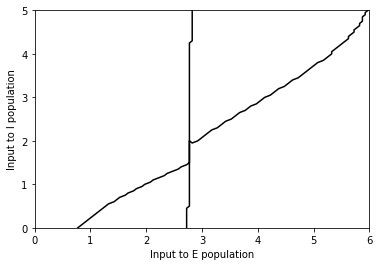

In [7]:
plt.plot(boundary_LC_e, boundary_LC_i, color='black')
plt.plot(boundary_bi_e, boundary_bi_i, color='black')
plt.xlabel('Input to E population')
plt.ylabel('Input to I population')
plt.xlim(0,6)
plt.ylim(0,5)

plt.show()

In [8]:
with open('boundary_osc.pickle','wb') as f:
    pickle.dump([boundary_LC_e, boundary_LC_i], f)
    
with open('boundary_bi.pickle','wb') as f:
    pickle.dump([boundary_bi_e, boundary_bi_i], f)